In [1]:
import pickle
#Run this with >bokeh serve --show TextAnalysis.ipynb
import pandas as pd
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from bokeh.io import curdoc,curstate
from bokeh.layouts import widgetbox
import time

from bokeh.layouts import layout,column,row
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource,Slider
from bokeh.palettes import Spectral6

from bokeh.models.widgets import Panel, Tabs
from bokeh.models.callbacks import CustomJS

import datashader as ds
import xarray
import time
import collections
import datashader.transfer_functions as tf

In [2]:
from bokeh.io import output_notebook, push_notebook
output_notebook()

Loading BokehJS ...

In [3]:
dict_=pickle.load(open('output_large.pkl','rb'))
print(dict_.keys())

dict_keys(['lstm_output', 'y_pred', 'y_val'])


In [ ]:
lstm_output=dict_['lstm_output']
y_pred=dict_['y_pred']
y_val=dict_['y_val']

header=["col"+str(x) for x in range(0,len(lstm_output[0]))]
index=["data"+str(x) for x in range(len(lstm_output))]
lstm_df=pd.DataFrame(lstm_output,columns=header,index=index)

#Also  make a numpy array with just the vector representations of teh sentences.
lstm_matrix=lstm_df.as_matrix()

lstm_df['y_pred']=y_pred
lstm_df['y_val']=y_val


unique_pred=lstm_df['y_pred'].unique()
unique_val=lstm_df['y_val'].unique()
color_mapper={1:'red',2:'blue',3:'orange',4:'green',5:'pink'}

lstm_df=lstm_df.transpose()
lstm_df['index']=list(range(len(lstm_df)))
columns=lstm_df.columns

preds=lstm_df.loc["y_pred",:]
vals=lstm_df.loc["y_val",:]


In [74]:
x_range=(0,len(lstm_df))
y_range=((lstm_df.loc[:,columns[:3]].min()).min(),(lstm_df.loc[:,columns[:3]].max()).max()) 
cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
y_range

(-0.76497900485992432, 4.0)

In [54]:
%%time
aggs= collections.OrderedDict((c, cvs.line(lstm_df,'index', c)) for c in columns[:1])
img = tf.shade(aggs['data0'],cmap=['lightblue','darkblue'])

Wall time: 7.24 s


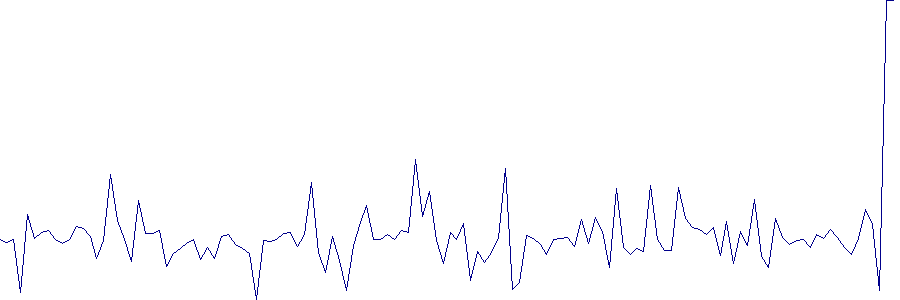

In [53]:
img

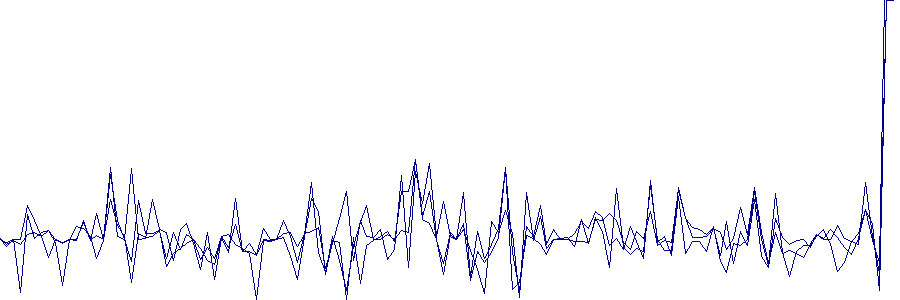

In [59]:
aggs= collections.OrderedDict((c, cvs.line(lstm_df,'index', c)) for c in columns[:3])
renamed = [aggs[key].rename({key: 'value'}) for key in aggs]
merged = xarray.concat(renamed, 'cols')
tf.shade(merged.any(dim='cols'))

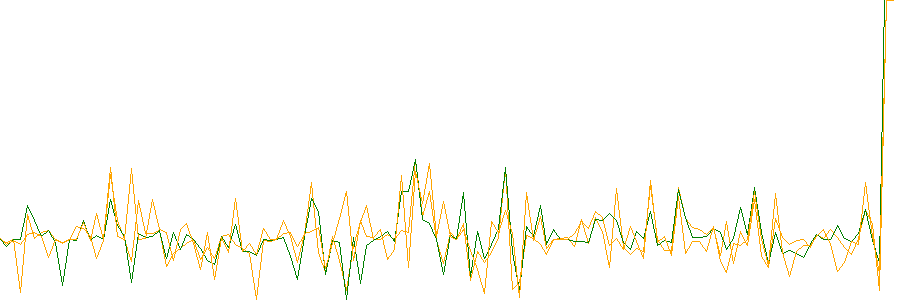

In [61]:
imgs = [tf.shade(aggs[i], cmap=[color_mapper[c]]) for i, c in zip(columns[:3],vals[:3])]
tf.stack(*imgs)

In [ ]:
from datashader.bokeh_ext import InteractiveImage
from bokeh.models import BoxZoomTool

def base_plot(tools='pan,wheel_zoom,reset'):
    p = figure(tools=tools, plot_width=600, plot_height=300,
        x_range=x_range, y_range=y_range)   
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.add_tools(BoxZoomTool(match_aspect=True))
    return p

def create_image(x_range, y_range, w, h,ncols=100):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range,
                    plot_height=h, plot_width=w)
    aggs = collections.OrderedDict((c,cvs.line(lstm_df, 'index', c, agg=ds.count())) for c in columns[:ncols])
    renamed = [aggs[key].rename({key: 'value'}) for key in aggs]
    merged = xarray.concat(renamed, 'cols')
    total = merged.sum(dim='cols')
    img = tf.shade(total, how='linear')
    return tf.dynspread(img)

p=base_plot()
InteractiveImage(p, create_image)

In [ ]:
ndim=128
df = ds.utils.dataframe_from_multiple_sequences(np.arange(ndim), lstm_matrix)
cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(df, 'x', 'y', ds.count())   
img = tf.shade(agg, how='eq_hist')
img

In [25]:
p = figure(plot_width=800, plot_height=350)

for col in columns[:3]:
    p.line(lstm_df['index'], lstm_df[col],legend=col,line_color=color_mapper[preds[col]],line_width=vals[col])
show(p)
#suffers from over plotting and plotting-order.